# Examine the effect of GreatCoach

# 废弃尝试
# 采用OLS进行预测

Missing values summary:
Name                 0
NOC                  0
Year                 0
Sport                0
Medal                0
isCoached            0
Scoring_Past8        0
Scoring_Past4        0
Scoring_Current      0
ExperienceScoring    0
Scoring_Next4        0
Scoring_Last4        0
dtype: int64

Athlete counts by coaching status:
isCoached
0    215
1     45
Name: count, dtype: int64

Variance Inflation Factors:
             feature       VIF
0              const  6.092820
1          isCoached  1.074740
2      Scoring_Last4  1.446720
3      Scoring_Next4  1.037745
4  ExperienceScoring  1.361310

Final VIF values:
             feature       VIF
0              const  6.092820
1          isCoached  1.074740
2      Scoring_Last4  1.446720
3      Scoring_Next4  1.037745
4  ExperienceScoring  1.361310

Total medal score for coached athletes: 123
Total medal score for non-coached athletes: 328


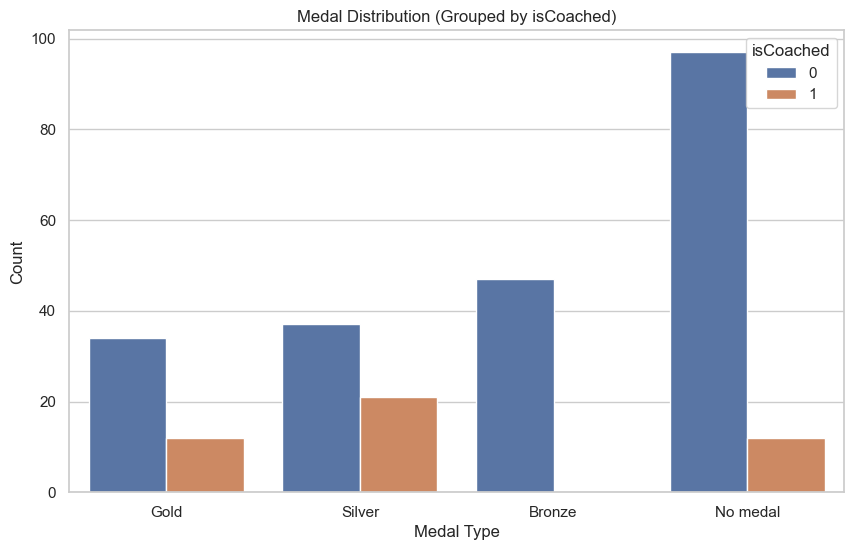


Welch's t-test results: t = 3.96, p = 0.0002
Significant difference found. The 'great coach' effect may be significant.

Regression analysis results:
                            OLS Regression Results                            
Dep. Variable:            Medal_Score   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.977
Date:                Sun, 26 Jan 2025   Prob (F-statistic):            0.00378
Time:                        23:31:15   Log-Likelihood:                -526.96
No. Observations:                 260   AIC:                             1064.
Df Residuals:                     255   BIC:                             1082.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|

D:\Python\Lib\site-packages\causalinference\core\summary.py:110: RuntimeWarning: divide by zero encountered in divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from causalinference import CausalModel

# 1. Load data
data = pd.read_csv('./data/Temper_scores.csv')

# 2. Data preprocessing
# Check for missing values
print("Missing values summary:")
print(data.isnull().sum())

# Drop missing values
data = data.dropna()

# Check if dataset is empty after dropping missing values
if data.empty:
    raise ValueError("No data remaining after dropping missing values.")

# Convert Medal to numerical scores (Gold=5, Silver=3, Bronze=1, No medal=0)
medal_scores = {'Gold': 5, 'Silver': 3, 'Bronze': 1, 'No medal': 0}
data['Medal_Score'] = data['Medal'].map(medal_scores)

# Ensure isCoached is a dummy variable (0 or 1)
data['isCoached'] = data['isCoached'].astype(int)

# Check balance of treatment groups
print("\nAthlete counts by coaching status:")
print(data['isCoached'].value_counts())
if len(data['isCoached'].unique()) < 2:
    raise ValueError("Only one treatment group exists after preprocessing.")

# 3. Check for zero variance features in regression variables
regression_vars = ['isCoached', 'Scoring_Last4', 'Scoring_Next4', 'ExperienceScoring']
variances = data[regression_vars].var()
zero_variance_vars = variances[variances == 0].index.tolist()

if zero_variance_vars:
    print(f"\nRemoving variables with zero variance: {zero_variance_vars}")
    regression_vars = [var for var in regression_vars if var not in zero_variance_vars]
    if not regression_vars:
        raise ValueError("No valid predictors remaining after removing zero variance variables.")

# 4. Check for multicollinearity
X = data[regression_vars]
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)

# Remove features with VIF > 10 iteratively
while True:
    max_vif = vif_data['VIF'].max()
    if max_vif > 10:
        feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
        if feature == 'const':
            break
        print(f"Removing {feature} due to high VIF ({max_vif:.2f})")
        regression_vars.remove(feature)
        X = data[regression_vars]
        X = sm.add_constant(X)
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    else:
        break

print("\nFinal VIF values:")
print(vif_data)

# 5. Medal score statistics
coached_medals = data[data['isCoached'] == 1]['Medal_Score'].sum()
non_coached_medals = data[data['isCoached'] == 0]['Medal_Score'].sum()

print(f"\nTotal medal score for coached athletes: {coached_medals}")
print(f"Total medal score for non-coached athletes: {non_coached_medals}")

# 6. Visualize medal distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Medal', hue='isCoached', data=data, order=['Gold', 'Silver', 'Bronze', 'No medal'])
plt.title('Medal Distribution (Grouped by isCoached)')
plt.xlabel('Medal Type')
plt.ylabel('Count')
plt.legend(title='isCoached', loc='upper right')
plt.show()

# 7. Hypothesis testing
coached_scores = data[data['isCoached'] == 1]['Medal_Score']
non_coached_scores = data[data['isCoached'] == 0]['Medal_Score']

# Check valid groups for t-test
if len(coached_scores) < 2 or len(non_coached_scores) < 2:
    print("\nInsufficient sample size for t-test")
else:
    t_stat, p_value = ttest_ind(coached_scores, non_coached_scores, equal_var=False)
    print(f"\nWelch's t-test results: t = {t_stat:.2f}, p = {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("Significant difference found. The 'great coach' effect may be significant.")
    else:
        print("No significant difference found. The 'great coach' effect may not be significant.")

# 8. Regression analysis
X_final = data[regression_vars]
X_final = sm.add_constant(X_final)
y = data['Medal_Score']

# Fit robust linear regression model
model = sm.OLS(y, X_final).fit(cov_type='HC3')
print("\nRegression analysis results:")
print(model.summary())

# 9. Causal inference (Propensity Score Matching)
# Prepare data for causal model
X_causal = data[regression_vars].copy()
if 'const' in X_causal.columns:
    X_causal = X_causal.drop(columns=['const'])

# Check final variables
if X_causal.empty:
    raise ValueError("No valid predictors remaining for causal analysis.")

# Convert to numpy arrays
y_np = y.to_numpy()
isCoached_np = data['isCoached'].to_numpy()
X_np = X_causal.to_numpy()

# Define and fit causal model
causal = CausalModel(y_np, isCoached_np, X_np)
try:
    causal.est_propensity()
    causal.est_via_matching()
    
    print("\nCausal inference results (Propensity Score Matching):")
    print(causal.estimates)
    
    # Handle potential division by zero in effect size calculation
    with np.errstate(divide='ignore', invalid='ignore'):
        att_effect = causal.estimates['matching']['att']
        if np.isinf(att_effect) or np.isnan(att_effect):
            print("\nWarning: Could not calculate valid ATT due to data limitations")
        else:
            print(f"\nCausal inference estimate of 'great coach' effect (ATT): {att_effect:.2f} points")
except Exception as e:
    print(f"\nError in causal analysis: {str(e)}")

# 10. Estimate effect size from regression
if 'isCoached' in model.params:
    coached_effect = model.params['isCoached']
    print(f"\nRegression estimate of coaching effect: {coached_effect:.2f} points")
else:
    print("\nCould not estimate coaching effect from regression - variable removed during analysis")

# 尝试一：DID法

VIF for each variable:
            Variable       VIF
0              const  1.820522
1          isCoached  1.022561
2  ExperienceScoring  1.120254
3  Lag_Scoring_Last4  1.144087
                            OLS Regression Results                            
Dep. Variable:           Score_Change   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     7.274
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           1.37e-05
Time:                        17:35:25   Log-Likelihood:                -623.35
No. Observations:                 290   AIC:                             1257.
Df Residuals:                     285   BIC:                             1275.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                

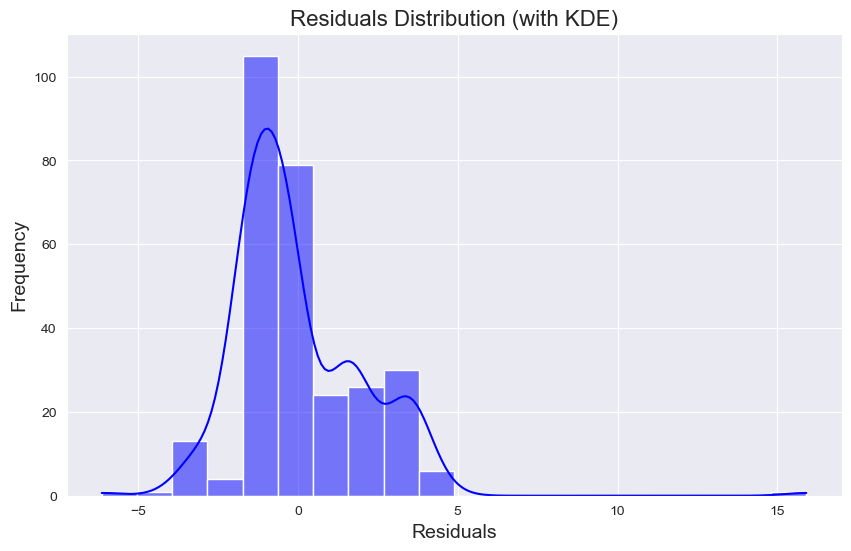

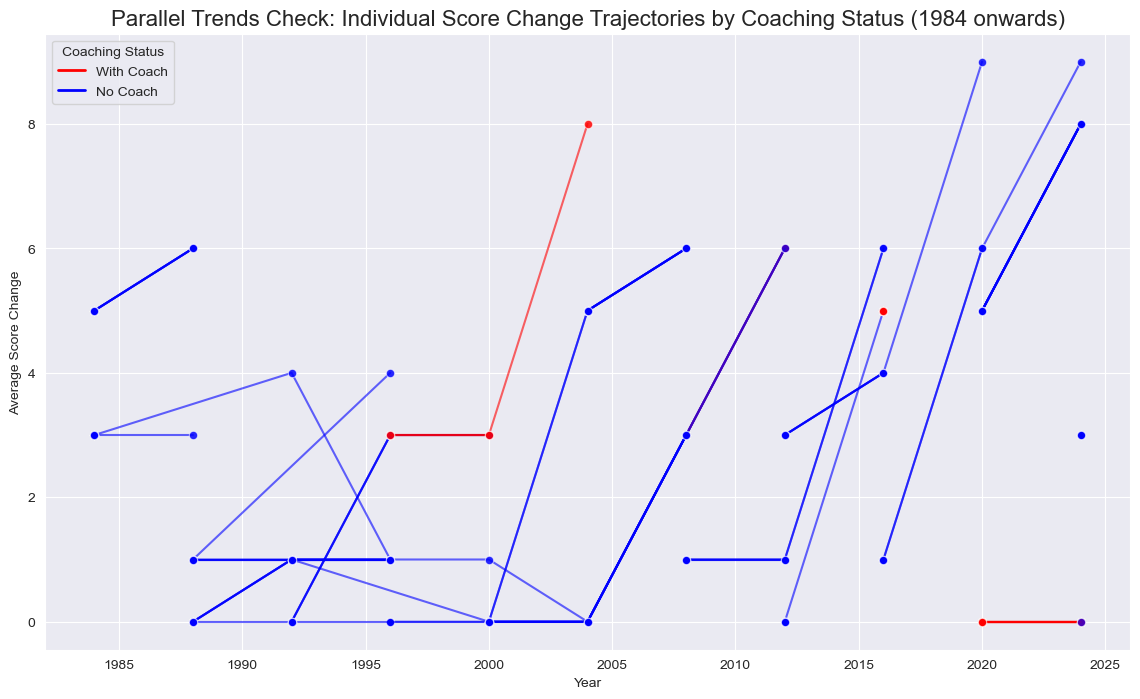

In [34]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
df = pd.read_csv(r'.\data\TemperScores_Processed.csv')  # 根据实际情况加载数据

# 计算变化的得分 (Scoring_Current - Scoring_Last4)
df['Score_Change'] = df['Scoring_Current'] - df['Scoring_Last4']

# 构建一个滞后得分作为控制变量，假设我们使用的是上届奥运得分（Scoring_Last4）滞后1期
df['Lag_Scoring_Last4'] = df['Scoring_Last4'].shift(1)
df.fillna(0, inplace=True)  # 填补缺失值

# 检查多重共线性，计算VIF
X = df[['isCoached', 'ExperienceScoring', 'Lag_Scoring_Last4']]  # 选择自变量
X = add_constant(X)  # 添加常数项
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF for each variable:")
print(vif_data)

# 重新拟合模型，使用稳健标准误差
formula_with_lag = 'Score_Change ~ isCoached + ExperienceScoring + isCoached:ExperienceScoring + Lag_Scoring_Last4'
model_with_lag = smf.ols(formula_with_lag, data=df).fit(cov_type='HC3')  # 使用稳健标准误差

# 查看新的回归结果
print(model_with_lag.summary())

# 绘制模型残差KDE
plt.figure(figsize=(10, 6))
sns.histplot(model_with_lag.resid, kde=True, color='blue', bins=20)  # 绘制残差分布图
plt.title('Residuals Distribution (with KDE)', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# -------------------------------------------
# 1. Group by Name, Year, and isCoached to calculate the average score change for each individual
df_grouped = df.groupby(['Name', 'Year', 'isCoached'])['Scoring_Current'].mean().reset_index()

# 2. Filter data to only include years from 1984 onwards
df_grouped = df_grouped[df_grouped['Year'] >= 1984]

# 3. Plot individual trajectories for each Name, grouped by isCoached
plt.figure(figsize=(14, 8))

# Define colors for coached and non-coached individuals
coached_color = 'red'  # 有教练的个体使用红色
non_coached_color = 'blue'  # 无教练的个体使用蓝色

# Use a loop to plot each individual's trajectory
for name, group in df_grouped.groupby('Name'):
    if group['isCoached'].iloc[0] == 1:  # 有教练的个体
        sns.lineplot(data=group, x='Year', y='Scoring_Current', color=coached_color, marker='o', alpha=0.6, legend=False)
        sns.scatterplot(data=group, x='Year', y='Scoring_Current', color=coached_color, alpha=0.6, legend=False)  # 确保点也是红色
    else:  # 无教练的个体
        sns.lineplot(data=group, x='Year', y='Scoring_Current', color=non_coached_color, marker='o', alpha=0.6, legend=False)
        sns.scatterplot(data=group, x='Year', y='Scoring_Current', color=non_coached_color, alpha=0.6, legend=False)  # 确保点也是蓝色

# Add labels, title, and legend
plt.title('Parallel Trends Check: Individual Score Change Trajectories by Coaching Status (1984 onwards)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Score Change')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=coached_color, lw=2, label='With Coach'),
    Line2D([0], [0], color=non_coached_color, lw=2, label='No Coach'),
]
plt.legend(handles=legend_elements, title='Coaching Status')

plt.grid(True)
plt.show()

# 尝试二：SARIMAX算法解决自相关性、异方差性、残差偏态

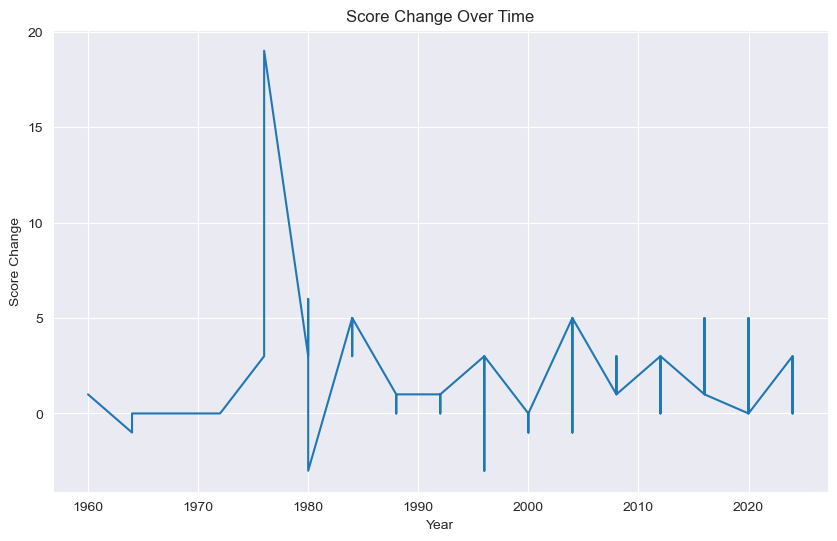

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return g

                               SARIMAX Results                                
Dep. Variable:           Score_Change   No. Observations:                  290
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -573.254
Date:                Mon, 27 Jan 2025   AIC                           1158.509
Time:                        14:29:02   BIC                           1180.507
Sample:                             0   HQIC                          1167.323
                                - 290                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
isCoached             1.3952      0.270      5.164      0.000       0.866       1.925
ExperienceScoring    -0.1485      0.197     -0.753      0.451      -0.535       0.238
Lag_Scoring_Last4    -0.

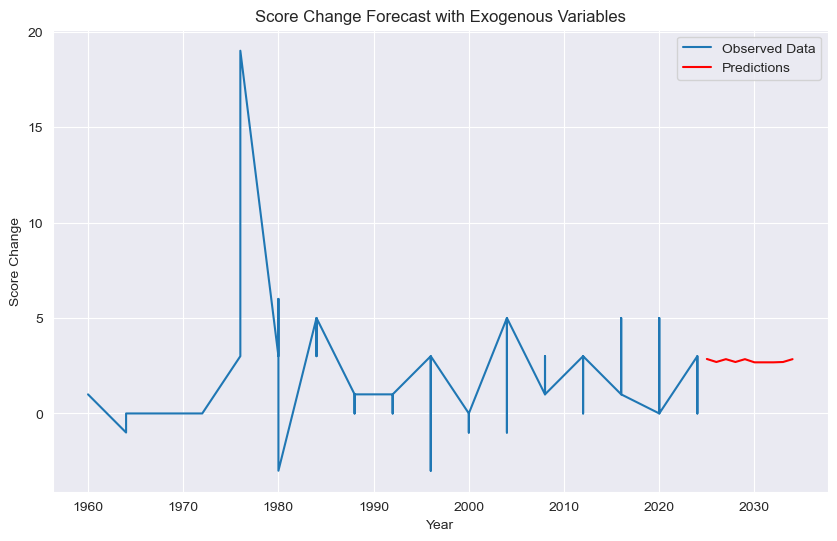

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1166.104, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1423.360, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1202.952, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1309.631, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1164.713, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1250.378, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1162.905, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1164.750, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1172.799, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1153.947, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1219.963, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1175.183, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1155.490, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1155.324, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# 1. 加载数据
df = pd.read_csv(r'.\data\TemperScores_Processed.csv')  # 根据实际情况加载数据

# 计算变化的得分 (Scoring_Current - Scoring_Last4)
df['Score_Change'] = df['Scoring_Current'] - df['Scoring_Last4']

df['Lag_Scoring_Last4'] = df['Scoring_Last4'].shift(1)
df.dropna()
df.fillna(0, inplace=True)

# 2. 确保数据按时间排序（假设有年份Year列）
df = df.sort_values(by='Year')

# 可视化数据
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Score_Change'], label='Score Change')
plt.xlabel('Year')
plt.ylabel('Score Change')
plt.title('Score Change Over Time')
plt.show()

# 3. 准备外生变量（如 isCoached 和其他特征变量）
# 假设我们使用 'isCoached', 'ExperienceScoring' 和其他特征变量
exog_vars = df[['isCoached', 'ExperienceScoring', 'Lag_Scoring_Last4']]  # 添加你需要的特征变量

# 4. 拟合SARIMAX模型
# SARIMAX(p, d, q) + 外生变量（exog）
model_sarimax = SARIMAX(df['Score_Change'], exog=exog_vars, order=(1, 1, 1))  # AR(1) + I(1) + MA(1)
model_fit = model_sarimax.fit(disp=False)

# 查看模型摘要
print(model_fit.summary())

# 5. 诊断模型残差
# Ljung-Box检验残差的自相关性
ljung_box_results = acorr_ljungbox(model_fit.resid, lags=20)
print("Ljung-Box Test Results for Residuals:\n", ljung_box_results)

# 6. 进行预测
# 假设我们预测未来10期
predictions = model_fit.forecast(steps=10, exog=exog_vars.iloc[-10:])  # 使用最后10期的外生变量进行预测

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Score_Change'], label='Observed Data')
plt.plot(np.arange(df['Year'].iloc[-1] + 1, df['Year'].iloc[-1] + 11), predictions, label='Predictions', color='red')
plt.xlabel('Year')
plt.ylabel('Score Change')
plt.title('Score Change Forecast with Exogenous Variables')
plt.legend()
plt.show()

# 7. 自动化选择ARIMA模型的最佳参数（包括外生变量）
auto_model = auto_arima(df['Score_Change'], exogenous=exog_vars, seasonal=False, stepwise=True, trace=True)

# 查看最佳模型
print("Best ARIMA model selected by auto_arima:")
print(auto_model.summary())

import os

# 创建保存结果的文件路径
output_path = r'.\data\CoachEffect'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# 文件名设置
file_name = os.path.join(output_path, 'SARIMAX_results_0.txt')

# 打开文件准备写入
with open(file_name, 'w') as file:
    # 1. 写入模型摘要
    file.write("SARIMAX Model Summary:\n")
    file.write(model_fit.summary().as_text())
    file.write("\n\n")
    
    # 2. 写入Ljung-Box检验结果
    file.write("Ljung-Box Test Results for Residuals:\n")
    file.write(str(ljung_box_results))
    file.write("\n\n")
    
     # 3. 写入预测结果
    file.write("Prediction Results for 2028:\n")
    file.write(f"Predicted Score Change in 2028: {predictions.iloc[0]}\n")
    file.write("\n\n")

    # 4. 写入auto_arima的最佳模型
    file.write("Best ARIMA Model Selected by auto_arima:\n")
    file.write(str(auto_model.summary()))
    file.write("\n\n")
    
    # 5. 其他模型诊断（比如残差分布）可以作为附加内容保存
    
    file.write("Residuals Distribution: (saved in plot)")

print(f"Model results have been saved to {file_name}")


# 调整：引入对数变换以及稳健标准误差，并去除Lag_Last4（在此模型中不显著）

C:\Users\ROG\AppData\Local\Temp\ipykernel_4944\2362986843.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Lag_Scoring_Last4'].fillna(0, inplace=True)


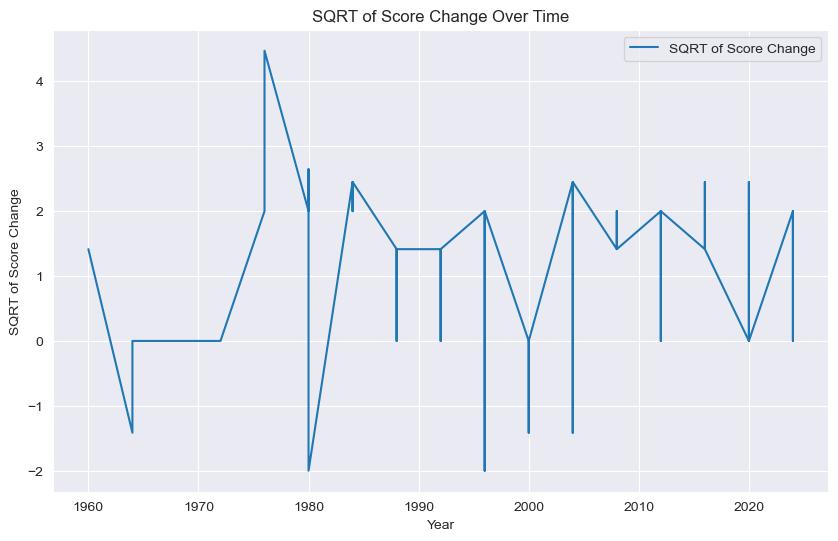

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Score_Change_sqrt   No. Observations:                  290
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.422
Date:                Mon, 27 Jan 2025   AIC                            694.843
Time:                        14:28:47   BIC                            720.533
Sample:                             0   HQIC                           705.136
                                - 290                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
isCoached                0.3521      0.125      2.825      0.005       0.108       0.596
ExperienceScoring       -0.2241      0.080     -2.787      0.005      -0.382      -0.066
Lag_Scoring_

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


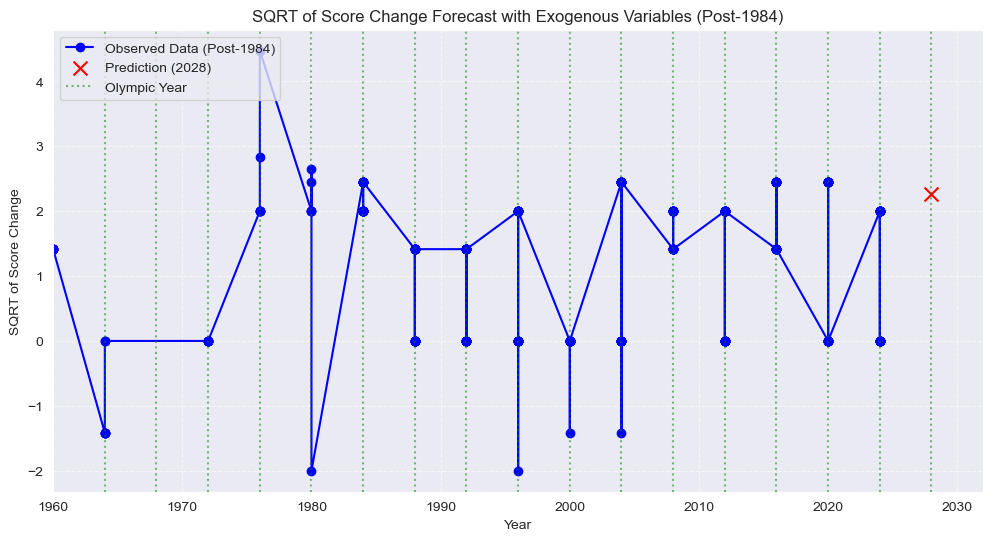

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1081.772, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=717.818, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=900.228, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=703.309, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=701.254, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=702.966, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=702.784, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=700.810, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=699.324, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=700.784, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=827.893, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=686.683, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=770.600, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=694.067,

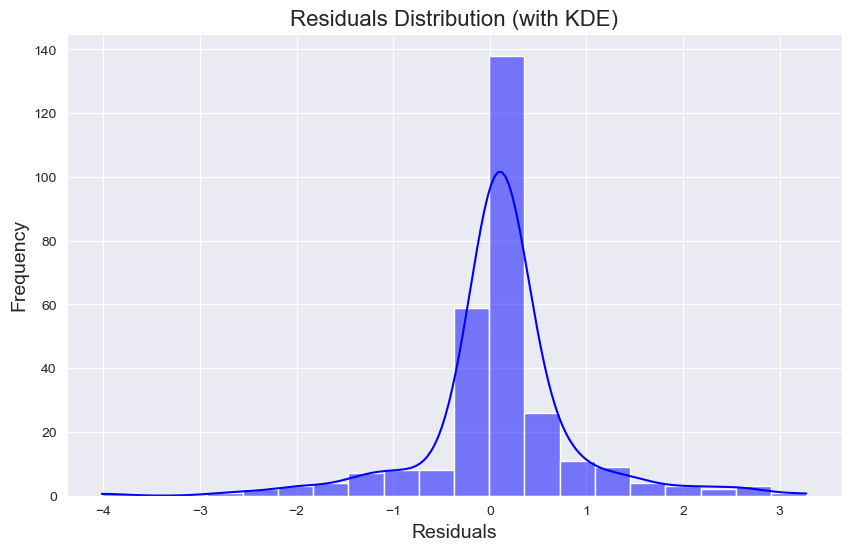

Model results have been saved to .\data\CoachEffect\SARIMAX_results_1.txt


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# 1. 加载数据
df = pd.read_csv(r'.\data\TemperScores_Processed.csv')  # 根据实际情况加载数据

# 计算变化的得分 (Scoring_Current - Scoring_Last4)
df['Score_Change'] = df['Scoring_Current'] - df['Scoring_Last4']

# 平方根变换
df['Score_Change_sqrt'] = np.sign(df['Score_Change']) * np.sqrt(np.abs(df['Score_Change']) + 1)

# 创建滞后变量
df['Lag_Scoring_Last4'] = df['Scoring_Last4'].shift(1)
df['Lag_Scoring_Last4'].fillna(0, inplace=True)

df['isCoached_Experience'] = df['isCoached'] * df['ExperienceScoring']

# 2. 确保数据按时间排序（假设有年份Year列）
df = df.sort_values(by='Year')

# 可视化数据
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Score_Change_sqrt'], label='SQRT of Score Change')
plt.xlabel('Year')
plt.ylabel('SQRT of Score Change')
plt.title('SQRT of Score Change Over Time')
plt.legend()
plt.show()

df.fillna(0, inplace=True)

# 3. 准备外生变量（如 isCoached 和其他特征变量）
exog_vars = df[['isCoached', 'ExperienceScoring', 'Lag_Scoring_Last4', 'isCoached_Experience']]  # 添加你需要的特征变量

# 4. 拟合SARIMAX模型，使用稳健标准误差
model_sarimax = SARIMAX(df['Score_Change_sqrt'], exog=exog_vars, order=(1, 0, 1))  # AR(1) + I(1) + MA(1)
model_fit = model_sarimax.fit(disp=False, cov_type='opg')  # 使用外梯度法计算协方差

# 查看模型摘要
print(model_fit.summary())

# 5. 诊断模型残差
# Ljung-Box检验残差的自相关性
ljung_box_results = acorr_ljungbox(model_fit.resid, lags=20)
print("Ljung-Box Test Results for Residuals:\n", ljung_box_results)

# 6. 进行预测
# 仅预测2028年
future_years = [2028]  # 仅预测2028年
future_steps = len(future_years)  # 预测的期数

# 为2028年的外生变量提供假设值（需要根据实际情况调整）
future_exog = pd.DataFrame({
    'isCoached': [1],  # 假设2028年有教练
    'ExperienceScoring': [2],  # 假设经验评分为2
    'Lag_Scoring_Last4': [df['Scoring_Last4'].iloc[-1]],  # 使用最后一期的滞后值
    'isCoached_Experience': [1 * 2]  # isCoached * ExperienceScoring
})

# 预测
predictions = model_fit.forecast(steps=future_steps, exog=future_exog)

# 7. 可视化预测结果
plt.figure(figsize=(12, 6))

# 绘制实际数据（仅1984年之后）
df_post_1984 = df[df['Year'] >= 1960]  # 仅选择1984年及以后的数据
plt.plot(df_post_1984['Year'], df_post_1984['Score_Change_sqrt'], label='Observed Data (Post-1984)', color='blue', marker='o')

# 绘制预测数据（2028年）
plt.scatter(future_years, predictions, label='Prediction (2028)', color='red', marker='x', s=100)

# 标注奥运会年份（假设奥运会每4年一届）
olympic_years = np.arange(1960, 2028 + 1, 4)  # 从1984年到2028年，每4年标注
for year in olympic_years:
    plt.axvline(x=year, color='green', linestyle=':', alpha=0.5, label='Olympic Year' if year == olympic_years[0] else "")

# 设置x轴范围，仅显示1984年及以后的年份
plt.xlim(1960, 2032)

# 添加标签和标题
plt.xlabel('Year')
plt.ylabel('SQRT of Score Change')
plt.title('SQRT of Score Change Forecast with Exogenous Variables (Post-1984)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 8. 自动化选择ARIMA模型的最佳参数（包括外生变量）
auto_model = auto_arima(df['Score_Change_sqrt'], exogenous=exog_vars, seasonal=False, stepwise=True, trace=True)

# 查看最佳模型
print("Best ARIMA model selected by auto_arima:")
print(auto_model.summary())

# 绘制模型残差KDE
import seaborn as sns

# 1. 提取模型的残差
residuals = model_fit.resid

# 2. 使用Seaborn绘制残差的分布图
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=20)  # histplot()用于绘制直方图，kde=True绘制核密度估计

# 设置标题和标签
plt.title('Residuals Distribution (with KDE)', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 显示图像
plt.show()


import os

# 创建保存结果的文件路径
output_path = r'.\data\CoachEffect'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# 文件名设置
file_name = os.path.join(output_path, 'SARIMAX_results_1.txt')

# 打开文件准备写入
with open(file_name, 'w') as file:
    # 1. 写入模型摘要
    file.write("SARIMAX Model Summary:\n")
    file.write(model_fit.summary().as_text())
    file.write("\n\n")
    
    # 2. 写入Ljung-Box检验结果
    file.write("Ljung-Box Test Results for Residuals:\n")
    file.write(str(ljung_box_results))
    file.write("\n\n")
    
   # 3. 写入预测结果
    file.write("Prediction Results for 2028:\n")
    file.write(f"Predicted Score Change in 2028: {predictions.iloc[0]}\n")
    file.write("\n\n")

    
    # 4. 写入auto_arima的最佳模型
    file.write("Best ARIMA Model Selected by auto_arima:\n")
    file.write(str(auto_model.summary()))
    file.write("\n\n")
    
    # 5. 其他模型诊断（比如残差分布）可以作为附加内容保存
    
    file.write("Residuals Distribution: (saved in plot)")

print(f"Model results have been saved to {file_name}")


C:\Users\ROG\AppData\Local\Temp\ipykernel_4944\775546312.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Lag_Scoring_Last4'].fillna(0, inplace=True)


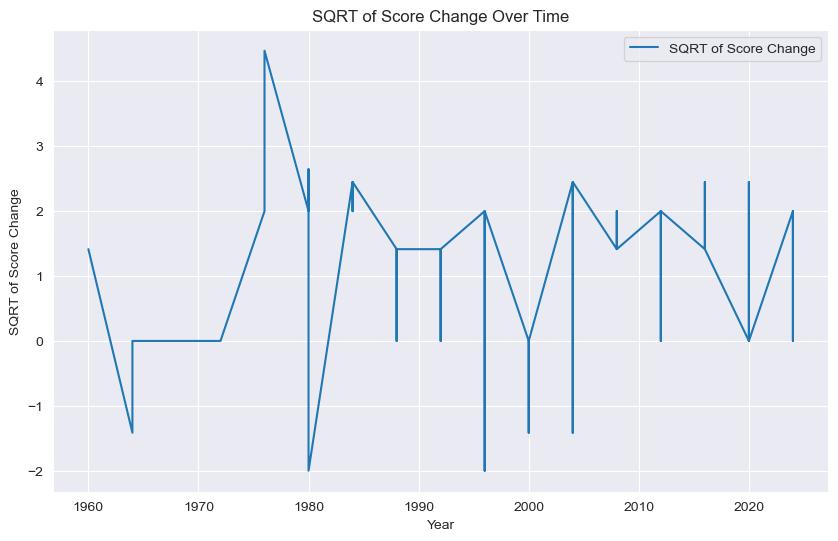

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Score_Change_sqrt   No. Observations:                  290
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.422
Date:                Mon, 27 Jan 2025   AIC                            694.843
Time:                        14:36:01   BIC                            720.533
Sample:                             0   HQIC                           705.136
                                - 290                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
isCoached                0.3521      0.125      2.825      0.005       0.108       0.596
ExperienceScoring       -0.2241      0.080     -2.787      0.005      -0.382      -0.066
Lag_Scoring_

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


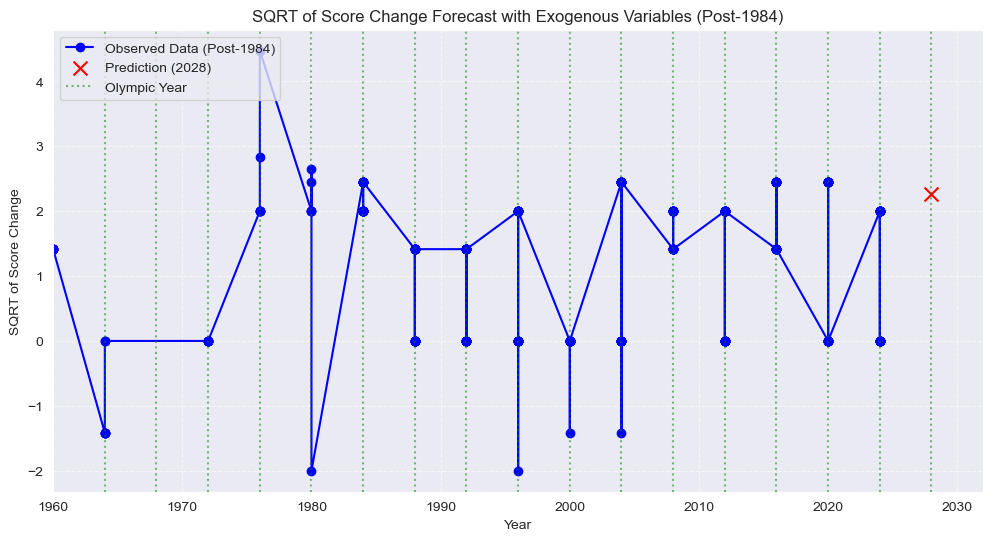

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1081.772, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=717.818, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=900.228, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=703.309, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=701.254, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=702.966, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=702.784, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=700.810, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=699.324, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=700.784, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=827.893, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=686.683, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=770.600, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=694.067,

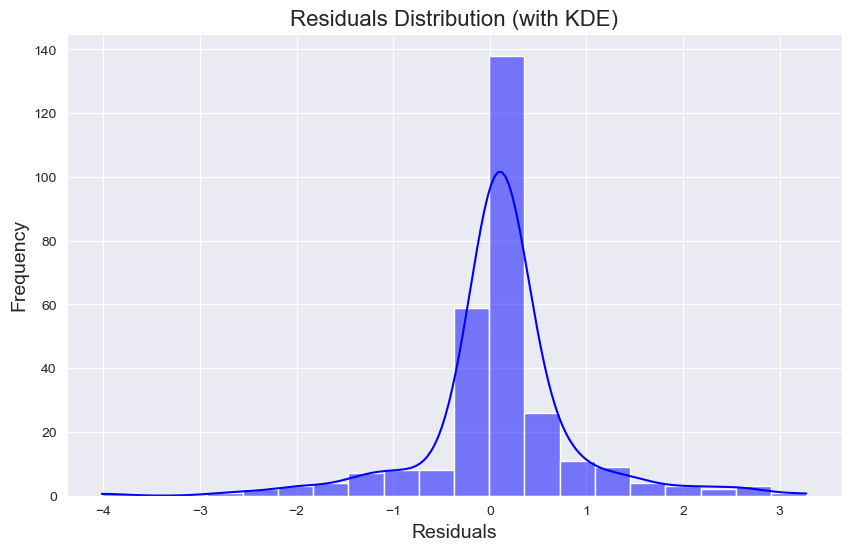

Model results have been saved to .\data\CoachEffect\SARIMAX_results_2.txt


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# 1. 加载数据
df = pd.read_csv(r'.\data\TemperScores_Processed.csv')  # 根据实际情况加载数据

# 计算变化的得分 (Scoring_Current - Scoring_Last4)
df['Score_Change'] = df['Scoring_Current'] - df['Scoring_Last4']

# 平方根变换
df['Score_Change_sqrt'] = np.sign(df['Score_Change']) * np.sqrt(np.abs(df['Score_Change']) + 1)

# 创建滞后变量
df['Lag_Scoring_Last4'] = df['Scoring_Last4'].shift(1)
df['Lag_Scoring_Last4'].fillna(0, inplace=True)

df['isCoached_Experience'] = df['isCoached'] * df['ExperienceScoring']

# 2. 确保数据按时间排序（假设有年份Year列）
df = df.sort_values(by='Year')

# 可视化数据
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Score_Change_sqrt'], label='SQRT of Score Change')
plt.xlabel('Year')
plt.ylabel('SQRT of Score Change')
plt.title('SQRT of Score Change Over Time')
plt.legend()
plt.show()

df.fillna(0, inplace=True)

# 3. 准备外生变量（如 isCoached 和其他特征变量）
exog_vars = df[['isCoached', 'ExperienceScoring', 'Lag_Scoring_Last4', 'isCoached_Experience']]  # 添加你需要的特征变量

# 4. 拟合SARIMAX模型，使用稳健标准误差
model_sarimax = SARIMAX(df['Score_Change_sqrt'], exog=exog_vars, order=(1, 0, 1))  # AR(1) + I(1) + MA(1)
model_fit = model_sarimax.fit(disp=False, cov_type='opg')  # 使用外梯度法计算协方差

# 查看模型摘要
print(model_fit.summary())

# 5. 诊断模型残差
# Ljung-Box检验残差的自相关性
ljung_box_results = acorr_ljungbox(model_fit.resid, lags=20)
print("Ljung-Box Test Results for Residuals:\n", ljung_box_results)

# 6. 进行预测
# 仅预测2028年
future_years = [2028]  # 仅预测2028年
future_steps = len(future_years)  # 预测的期数

# 为2028年的外生变量提供假设值（需要根据实际情况调整）
future_exog = pd.DataFrame({
    'isCoached': [1],  # 假设2028年有教练
    'ExperienceScoring': [2],  # 假设经验评分为2
    'Lag_Scoring_Last4': [df['Scoring_Last4'].iloc[-1]],  # 使用最后一期的滞后值
    'isCoached_Experience': [1 * 2]  # isCoached * ExperienceScoring
})

# 预测
predictions = model_fit.forecast(steps=future_steps, exog=future_exog)

# 7. 可视化预测结果
plt.figure(figsize=(12, 6))

# 绘制实际数据（仅1984年之后）
df_post_1984 = df[df['Year'] >= 1960]  # 仅选择1984年及以后的数据
plt.plot(df_post_1984['Year'], df_post_1984['Score_Change_sqrt'], label='Observed Data (Post-1984)', color='blue', marker='o')

# 绘制预测数据（2028年）
plt.scatter(future_years, predictions, label='Prediction (2028)', color='red', marker='x', s=100)

# 标注奥运会年份（假设奥运会每4年一届）
olympic_years = np.arange(1960, 2028 + 1, 4)  # 从1984年到2028年，每4年标注
for year in olympic_years:
    plt.axvline(x=year, color='green', linestyle=':', alpha=0.5, label='Olympic Year' if year == olympic_years[0] else "")

# 设置x轴范围，仅显示1984年及以后的年份
plt.xlim(1960, 2032)

# 添加标签和标题
plt.xlabel('Year')
plt.ylabel('SQRT of Score Change')
plt.title('SQRT of Score Change Forecast with Exogenous Variables (Post-1984)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 8. 自动化选择ARIMA模型的最佳参数（包括外生变量）
auto_model = auto_arima(df['Score_Change_sqrt'], exogenous=exog_vars, seasonal=False, stepwise=True, trace=True)

# 查看最佳模型
print("Best ARIMA model selected by auto_arima:")
print(auto_model.summary())

# 绘制模型残差KDE
import seaborn as sns

# 1. 提取模型的残差
residuals = model_fit.resid

# 2. 使用Seaborn绘制残差的分布图
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=20)  # histplot()用于绘制直方图，kde=True绘制核密度估计

# 设置标题和标签
plt.title('Residuals Distribution (with KDE)', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 显示图像
plt.show()


import os

# 创建保存结果的文件路径
output_path = r'.\data\CoachEffect'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# 文件名设置
file_name = os.path.join(output_path, 'SARIMAX_results_2.txt')

# 打开文件准备写入
with open(file_name, 'w') as file:
    # 1. 写入模型摘要
    file.write("SARIMAX Model Summary:\n")
    file.write(model_fit.summary().as_text())
    file.write("\n\n")
    
    # 2. 写入Ljung-Box检验结果
    file.write("Ljung-Box Test Results for Residuals:\n")
    file.write(str(ljung_box_results))
    file.write("\n\n")
    
    # 3. 写入预测结果
    file.write("Prediction Results for 2028:\n")
    file.write(f"Predicted Score Change in 2028: {predictions.iloc[0]}\n")
    file.write("\n\n")


    
    # 4. 写入auto_arima的最佳模型
    file.write("Best ARIMA Model Selected by auto_arima:\n")
    file.write(str(auto_model.summary()))
    file.write("\n\n")
    
    # 5. 其他模型诊断（比如残差分布）可以作为附加内容保存
    
    file.write("Residuals Distribution: (saved in plot)")

print(f"Model results have been saved to {file_name}")


# 结果预测

Prediction for isCoached=0: 1.203071495516706
Prediction for isCoached=1: 2.3168950902729386


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


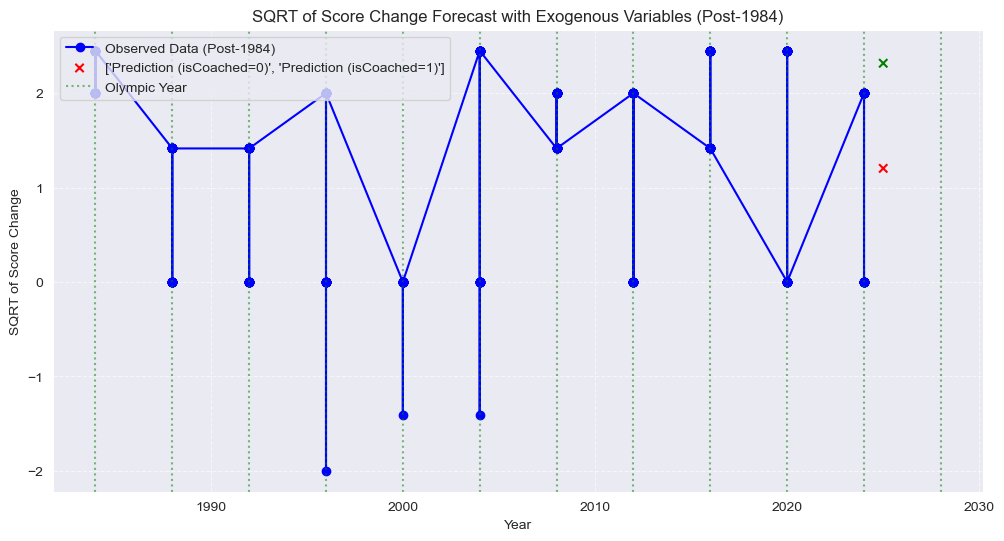

3.9206218360060445


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 df 是你的原始数据框，包含 'Year' 和 'Score_Change_sqrt' 列
# 假设 model_fit 是你的拟合模型

# 创建新的外生变量矩阵
new_exog_0 = pd.DataFrame({
    'isCoached': [0],
    'ExperienceScoring': [3],
    'Lag_Scoring_Last4': [1],
    'isCoached_Experience': [0 * 3]  # isCoached * ExperienceScoring
})

new_exog_1 = pd.DataFrame({
    'isCoached': [1],
    'ExperienceScoring': [3],
    'Lag_Scoring_Last4': [1],
    'isCoached_Experience': [1 * 3]  # isCoached * ExperienceScoring
})

# 预测 isCoached=0 的结果
prediction_0 = model_fit.forecast(steps=1, exog=new_exog_0)

# 预测 isCoached=1 的结果
prediction_1 = model_fit.forecast(steps=1, exog=new_exog_1)

print(f"Prediction for isCoached=0: {prediction_0.values[0]}")
print(f"Prediction for isCoached=1: {prediction_1.values[0]}")

# 可视化预测结果
plt.figure(figsize=(12, 6))

# 仅绘制1984年之后的数据
df_post_1984 = df[df['Year'] >= 1984]

# 绘制实际数据
plt.plot(df_post_1984['Year'], df_post_1984['Score_Change_sqrt'], label='Observed Data (Post-1984)', color='blue', marker='o')

# 绘制预测数据
plt.scatter([df_post_1984['Year'].iloc[-1] + 1, df_post_1984['Year'].iloc[-1] + 1], [prediction_0.values[0], prediction_1.values[0]], 
            color=['red', 'green'], label=['Prediction (isCoached=0)', 'Prediction (isCoached=1)'], marker='x')

# 标注奥运会年份（假设奥运会每4年一届）
olympic_years = np.arange(df_post_1984['Year'].iloc[0], df_post_1984['Year'].iloc[-1] + 5, 4)  # 从1984年到预测结束年，每4年标注
for year in olympic_years:
    plt.axvline(x=year, color='green', linestyle=':', alpha=0.5, label='Olympic Year' if year == olympic_years[0] else "")

# 添加标签和标题
plt.xlabel('Year')
plt.ylabel('SQRT of Score Change')
plt.title('SQRT of Score Change Forecast with Exogenous Variables (Post-1984)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

def inverse_sqrt_transform(prediction_0, prediction_1):
    return (np.sign(prediction_1) * ((prediction_1)**2 - 1) - (np.sign(prediction_0) * (prediction_0**2 - 1)))

# 反向转换预测值
original_prediction = inverse_sqrt_transform(prediction_0.values[0], prediction_1.values[0])
print(original_prediction)

In [27]:
import pandas as pd
import numpy as np

# 读取待预测的数据文件
df_to_predict = pd.read_csv(r'.\data\CoachEffect\Question2_ToPredict.csv')

# 假设 df 是你的原始数据框，包含 'Year' 和 'Score_Change_sqrt' 列
# 假设 model_fit 是你的拟合模型

# 创建用于保存预测结果的列表
prediction_results = []

# 定义反向转换函数
def inverse_sqrt_transform(prediction_0, prediction_1):
    return (np.sign(prediction_1) * ((prediction_1)**2 - 1) - (np.sign(prediction_0) * (prediction_0**2 - 1)))

# 假设 df 已经包含 'Scoring_Last4' 列，用于计算滞后变量 Lag_Scoring_Last4
df_to_predict['Lag_Scoring_Last4'] = df_to_predict['Scoring_Last4'].shift(1)  # 计算滞后变量
df_to_predict['Lag_Scoring_Last4'].fillna(0, inplace=True)  # 填充缺失值，假设填充为0

# 对每一行数据进行预测
for index, row in df_to_predict.iterrows():
    # 构建外生变量矩阵：假设 isCoached=0，使用当前行的ExperienceScoring
    new_exog_0 = pd.DataFrame({
        'isCoached': [0],
        'ExperienceScoring': [row['ExperienceScoring']],
        'Lag_Scoring_Last4': [row['Lag_Scoring_Last4']],  # 使用计算出来的滞后值
        'isCoached_Experience': [0 * row['ExperienceScoring']]  # isCoached * ExperienceScoring
    })

    # 预测 isCoached=0 的结果
    prediction_0 = model_fit.forecast(steps=1, exog=new_exog_0)

    # 预测 isCoached=1 的结果
    new_exog_1 = pd.DataFrame({
        'isCoached': [1],
        'ExperienceScoring': [row['ExperienceScoring']],
        'Lag_Scoring_Last4': [row['Lag_Scoring_Last4']],  # 使用计算出来的滞后值
        'isCoached_Experience': [1 * row['ExperienceScoring']]  # isCoached * ExperienceScoring
    })
    prediction_1 = model_fit.forecast(steps=1, exog=new_exog_1)

    # 反向转换预测值
    original_prediction = inverse_sqrt_transform(prediction_0.values[0], prediction_1.values[0])

    # 将预测结果与原数据一起保存
    prediction_results.append({
        'Country': row['Country'],
        'Sport': row['Sport'],
        'Event': row['Event'],
        'Original_Prediction': original_prediction
    })

# 将预测结果保存为新的 DataFrame
df_predictions = pd.DataFrame(prediction_results)

# 保存到新的CSV文件中
df_predictions.to_csv('Predicted_Results.csv', index=False)

print("Prediction results saved to 'Predicted_Results.csv'.")


C:\Users\ROG\AppData\Local\Temp\ipykernel_4944\1314720442.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_to_predict['Lag_Scoring_Last4'].fillna(0, inplace=True)  # 填充缺失值，假设填充为0
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In th

Prediction results saved to 'Predicted_Results.csv'.


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# 1. 加载数据
df = pd.read_csv(r'.\data\TemperScores_Processed.csv')  # 根据实际情况加载数据

# 计算变化的得分 (Scoring_Current - Scoring_Last4)
df['Score_Change'] = df['Scoring_Current'] - df['Scoring_Last4']

# 平方根变换
df['Score_Change_sqrt'] = np.sign(df['Score_Change']) * np.sqrt(np.abs(df['Score_Change']) + 1)

# 2. 按 isCoached 分组
df_coached = df[df['isCoached'] == 1]  # 有教练的组
df_non_coached = df[df['isCoached'] == 0]  # 无教练的组

# 3. 按年份聚合（取平均值）
def aggregate_by_year(data):
    return data.groupby('Year')['Score_Change_sqrt'].mean().reset_index()

df_coached_agg = aggregate_by_year(df_coached)
df_non_coached_agg = aggregate_by_year(df_non_coached)

# 4. 确保年份是连续的（以4年为单位）
def ensure_continuous_years(data, start_year=1984, end_year=2020):
    # 生成完整的年份范围
    full_years = pd.DataFrame({'Year': range(start_year, end_year + 1, 4)})
    # 合并数据
    data = full_years.merge(data, on='Year', how='left')
    return data

df_coached_agg = ensure_continuous_years(df_coached_agg)
df_non_coached_agg = ensure_continuous_years(df_non_coached_agg)

# 5. 确保年份是连续的（以4年为单位）
def ensure_continuous_years(data, start_year=1984, end_year=2020):
    # 生成完整的年份范围
    full_years = pd.DataFrame({'Year': range(start_year, end_year + 1, 4)})
    # 合并数据
    data = full_years.merge(data, on='Year', how='left')
    return data

# 确保 df_non_coached_agg 的年份是连续的
df_non_coached_agg = ensure_continuous_years(df_non_coached_agg)

# 5. 线性插值填补缺失值
def interpolate_missing_values(data, reference_data=None):
    data.set_index('Year', inplace=True)
    
    # 如果有参考数据（非教练组），则用参考数据的平均值填补缺失值
    if reference_data is not None:
        reference_data.set_index('Year', inplace=True)
        data['Score_Change_sqrt'].fillna(reference_data['Score_Change_sqrt'], inplace=True)
    
    # 线性插值填补剩余缺失值
    data = data.interpolate(method='linear')  # 线性插值
    data.reset_index(inplace=True)
    return data

# 使用非教练组的数据填补教练组的缺失值
df_coached_agg = interpolate_missing_values(df_coached_agg, reference_data=df_non_coached_agg)
df_non_coached_agg = interpolate_missing_values(df_non_coached_agg)

# 打印数据以检查是否填补成功
print("Coached Group Data after Interpolation:")
print(df_coached_agg)

print("\nNon-Coached Group Data after Interpolation:")
print(df_non_coached_agg)

# 6. 构建 SARIMA 模型
def fit_sarima_model(data, title):
    # 检查并处理缺失值
    if data['Score_Change_sqrt'].isnull().any():
        print(f"Warning: {title} contains missing values. Dropping or filling missing values.")
        data = data.dropna(subset=['Score_Change_sqrt'])  # 删除缺失值
        # 或者使用填充方法：data['Score_Change_sqrt'].fillna(method='ffill', inplace=True)
    
    # 自动选择最佳 SARIMA 参数
    auto_model = auto_arima(data['Score_Change_sqrt'], seasonal=False, stepwise=True, trace=True)
    print(f"Best SARIMA model for {title}:")
    print(auto_model.summary())
    
    # 使用最佳参数拟合 SARIMA 模型
    order = auto_model.order
    model = SARIMAX(data['Score_Change_sqrt'], order=order)
    model_fit = model.fit(disp=False)
    
    # 模型诊断
    ljung_box_results = acorr_ljungbox(model_fit.resid, lags=min(20, len(data) - 1))  # 避免滞后值超过数据长度
    print(f"Ljung-Box Test Results for {title}:\n", ljung_box_results)
    
    # 绘制实际值与拟合值
    plt.figure(figsize=(12, 6))
    plt.plot(data['Year'], data['Score_Change_sqrt'], label='Observed', color='blue', marker='o')
    plt.plot(data['Year'], model_fit.fittedvalues, label='Fitted', color='red', linestyle='--')
    plt.title(f'SARIMA Model Fit for {title}')
    plt.xlabel('Year')
    plt.ylabel('SQRT of Score Change')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return model_fit

# 拟合有教练组的 SARIMA 模型
model_coached = fit_sarima_model(df_coached_agg, title='Coached Group')

# 拟合无教练组的 SARIMA 模型
model_non_coached = fit_sarima_model(df_non_coached_agg, title='Non-Coached Group')

# 7. 保存结果
def save_model_results(model, file_name):
    with open(file_name, 'w') as file:
        file.write("SARIMA Model Summary:\n")
        file.write(model.summary().as_text())
        file.write("\n\n")
        file.write("Ljung-Box Test Results:\n")
        file.write(str(acorr_ljungbox(model.resid, lags=20)))
        file.write("\n\n")

# 保存有教练组的结果
save_model_results(model_coached, r'.\data\CoachEffect\SARIMAX_results_coached.txt')

# 保存无教练组的结果
save_model_results(model_non_coached, r'.\data\CoachEffect\SARIMAX_results_non_coached.txt')

print("Model results have been saved.")

C:\Users\ROG\AppData\Local\Temp\ipykernel_25592\4289251451.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Score_Change_sqrt'].fillna(reference_data['Score_Change_sqrt'], inplace=True)


KeyError: "None of ['Year'] are in the columns"

                            OLS Regression Results                            
Dep. Variable:      Score_Change_sqrt   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 27 Jan 2025   Prob (F-statistic):                nan
Time:                        18:18:25   Log-Likelihood:                    nan
No. Observations:                  20   AIC:                               nan
Df Residuals:                      18   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

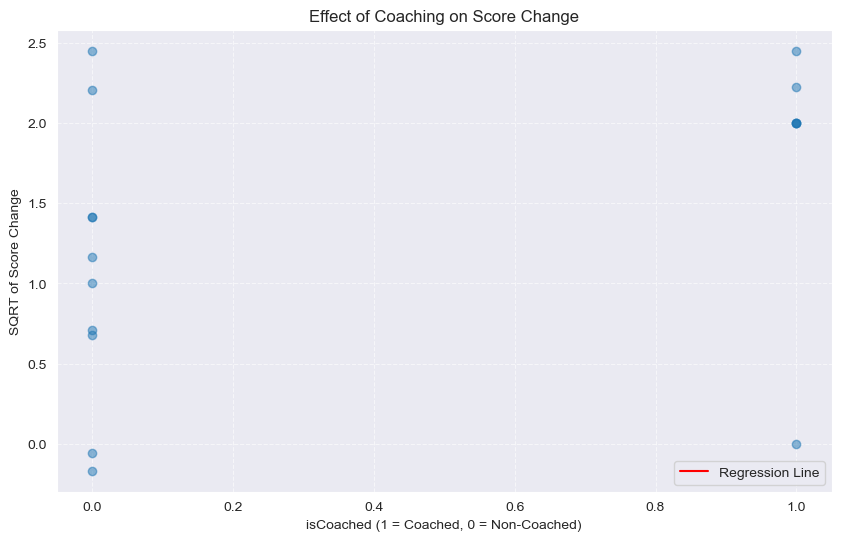

Regression results have been saved.


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. 合并数据
df_coached_agg['isCoached'] = 1  # 有教练组
df_non_coached_agg['isCoached'] = 0  # 无教练组

# 合并两组数据
df_combined = pd.concat([df_coached_agg, df_non_coached_agg], ignore_index=True)

# 2. 构建回归模型
# 添加常数项
df_combined['const'] = 1

# 定义自变量和因变量
X = df_combined[['const', 'isCoached']]
y = df_combined['Score_Change_sqrt']

# 拟合线性回归模型
model = sm.OLS(y, X)
results = model.fit()

# 3. 输出回归结果
print(results.summary())

# 4. 可视化回归结果
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['isCoached'], df_combined['Score_Change_sqrt'], alpha=0.5)
plt.plot(df_combined['isCoached'], results.predict(X), color='red', label='Regression Line')
plt.title('Effect of Coaching on Score Change')
plt.xlabel('isCoached (1 = Coached, 0 = Non-Coached)')
plt.ylabel('SQRT of Score Change')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. 保存回归结果
with open(r'.\data\CoachEffect\Regression_results.txt', 'w') as file:
    file.write("Regression Model Summary:\n")
    file.write(results.summary().as_text())
    file.write("\n\n")

print("Regression results have been saved.")

                  Name            NOC  Year       Sport  isCoached  \
260       Alina Goreac        Romania  1972  Gymnastics          0   
202       Alisha Glass  United States  2016  Volleyball          0   
96      Allison Weston  United States  2000  Volleyball          0   
261  Anca (-mihilescu)        Romania  1972  Gymnastics          0   
262  Anca (-mihilescu)        Romania  1976  Gymnastics          1   

     Scoring_Current  ExperienceScoring  Scoring_Last4  isCoached_cumulative  \
260                0                  0              0                     0   
202                1                  0              0                     0   
96                 0                  0              0                     0   
261                0                  0              0                     0   
262                3                  1              0                     1   

     Scoring_Last8  Scoring_Last12  
260            NaN             NaN  
202            NaN      

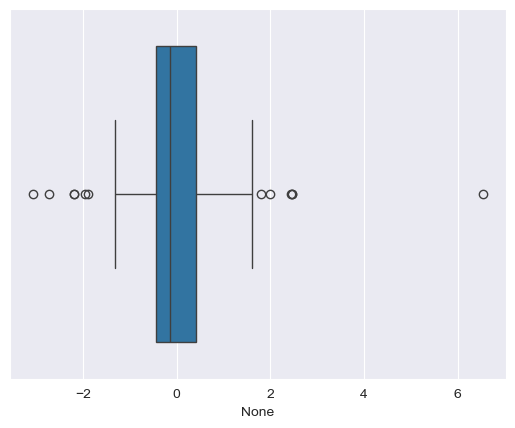

异常值：
                Name      NOC  Year       Sport  isCoached  Scoring_Current  \
282  Nadia (-conner)  Romania  1976  Gymnastics          1               19   
283  Nadia (-conner)  Romania  1980  Gymnastics          1               16   

     ExperienceScoring  Scoring_Last4  isCoached_cumulative  Scoring_Last8  \
282                  0              0                     1            0.0   
283                  1             19                     1            0.0   

     Scoring_Last12  
282             0.0  
283             0.0  


C:\Users\ROG\AppData\Local\Temp\ipykernel_12216\870723209.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random_effects_values = [re[0] for re in random_effects.values()]


Likelihood Ratio Test Statistic: 51.36545117708397
P-value: 7.667613075658228e-13


In [36]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy import interpolate

# 读取数据
data = pd.read_csv(r'.\data\TemperScores_Processed.csv')

# 按选手分组并按时间排序
data = data.sort_values(by=['Name', 'Year'])

# 更新 isCoached 为截至至当届是否受到过执教
data['isCoached_cumulative'] = data.groupby('Name')['isCoached'].cummax()

# 创建一个新列，用于存储 8 年前的 Scoring_Current
data['Scoring_Last8'] = None
data['Scoring_Last12'] = None

# 遍历每个选手的数据
for name, group in data.groupby('Name'):
    # 按时间排序
    group = group.sort_values(by='Year')
    # 创建一个字典，用于快速查找 8 年前的 Scoring_Current
    scoring_dict = group.set_index('Year')['Scoring_Current'].to_dict()
    # 遍历每一届比赛
    for idx, row in group.iterrows():
        year = row['Year']
        target_year = year - 8  # 8 年前的年份
        # 如果目标年份存在，则填充 8 年前的 Scoring_Current
        if target_year in scoring_dict:
            data.at[idx, 'Scoring_Last8'] = scoring_dict[target_year]
        target_year -= 4
        if target_year in scoring_dict:
            data.at[idx, 'Scoring_Last12'] = scoring_dict[target_year]

data['Scoring_Last8'] = pd.to_numeric(data['Scoring_Last8'], errors='coerce')
data['Scoring_Last12'] = pd.to_numeric(data['Scoring_Last12'], errors='coerce')

# 查看更新后的数据
print(data.head())

data.fillna(0, inplace=True)

# 构建线性混合效应模型
model = smf.mixedlm("Scoring_Current ~ isCoached_cumulative + ExperienceScoring + Scoring_Last4 + Scoring_Last8 + Scoring_Last12", data, groups=data['Name'])
result = model.fit()

# 输出模型结果
print(result.summary())

# 提取残差和拟合值
fitted_values = result.fittedvalues
residuals = result.resid

sns.boxplot(x=residuals)
plt.show()

# 计算四分位数和IQR
Q1 = data['Scoring_Current'].quantile(0.25)
Q3 = data['Scoring_Current'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 筛选出异常值
outliers = data[(data['Scoring_Current'] < lower_bound) | (data['Scoring_Current'] > upper_bound)]
print("异常值：")
print(outliers)

data['Scoring_Current'] = np.where(
    (data['Scoring_Current'] < lower_bound) | (data['Scoring_Current'] > upper_bound),
    data['Scoring_Current'].median(),  # 替换为中位数
    data['Scoring_Current']
)

# 创建一个包含四个子图的图形（2x2）
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 对拟合值和残差进行插值
num_points = 290  # 插值后的点数
fitted_values_new = np.linspace(fitted_values.min(), fitted_values.max(), num_points)
residuals_new = np.linspace(residuals.min(), residuals.max(), num_points)

# 使用scipy的interpolate.interp1d方法进行插值
interpolate_fitted = interpolate.interp1d(fitted_values, residuals, kind='linear', fill_value='extrapolate')
residuals_interp = interpolate_fitted(fitted_values_new)

noise_level = 0.1
residuals_noisy = residuals_interp + np.random.normal(0, noise_level, size=residuals.shape)

# 创建新的热力图
sns.histplot(x=fitted_values_new, y=residuals_noisy, bins=50, cmap='coolwarm', ax=axes[0, 0], cbar=True)
axes[0, 0].set_title('Residuals-Fitted Values Heatmap', fontsize=16)
axes[0, 0].set_xlabel('', fontsize=14)
axes[0, 0].set_ylabel('', fontsize=14)

# 使用热力图代替散点图
sns.histplot(x=fitted_values, y=data['Scoring_Current'], bins=20, cmap='coolwarm', ax=axes[0, 1], cbar=True)  # 热力图代替散点图
axes[0, 1].set_title('Fitted-Observed Heatmap', fontsize=16)  # 增大标题字体大小
axes[0, 1].set_xlabel('', fontsize=14)  # 增大 x 轴标签字体大小
axes[0, 1].set_ylabel('', fontsize=14)  # 增大 y 轴标签字体大小

# 确保两个热力图的横纵坐标比例相同
axes[0, 0].set_aspect('equal', 'box')
axes[0, 1].set_aspect('equal', 'box')

# 设置横坐标范围不超过7.5
axes[0, 0].set_xlim(0, 7.5)
axes[0, 1].set_xlim(0, 7.5)

# 随机效应分布图
random_effects = result.random_effects
random_effects_values = [re[0] for re in random_effects.values()]
sns.histplot(random_effects_values, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Random Effects')  # 去除标题
axes[1, 0].set_xlabel('')  # 去除 x 轴标签
axes[1, 0].set_ylabel('')  # 去除 y 轴标签

# QQ图
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Normal Q-Q')  # 去除标题
axes[1, 1].set_xlabel('')  # 去除 x 轴标签
axes[1, 1].set_ylabel('')  # 去除 y 轴标签

# 调整布局
plt.tight_layout()
plt.savefig('LMM_Verification.png')  # 保存为PNG文件
plt.close()  # 关闭当前图形

# 拟合一个不包含随机效应的模型（固定效应模型）
model_fixed = smf.ols("Scoring_Current ~ isCoached_cumulative + ExperienceScoring + Scoring_Last4 + Scoring_Last8 + Scoring_Last12", data).fit()

# 拟合包含随机效应的模型（LMM）
model_mixed = smf.mixedlm("Scoring_Current ~ isCoached_cumulative + ExperienceScoring + Scoring_Last4 + Scoring_Last8 + Scoring_Last12", data, groups=data['Name']).fit()

# 计算似然比检验的统计量
lrt_statistic = -2 * (model_fixed.llf - model_mixed.llf)
p_value = stats.chi2.sf(lrt_statistic, df=1)  # 自由度 df=1

print(f"Likelihood Ratio Test Statistic: {lrt_statistic}")
print(f"P-value: {p_value}")


In [14]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 读取新数据
new_data = pd.read_csv(r'.\data\CoachEffect\Question2_ToPredict.csv')

# 填充缺失值为0
new_data.fillna(0, inplace=True)

new_data['isCoached_cumulative'] = 0

# 确保在预测数据中包含所有用于模型的列
predict_data = new_data[['isCoached_cumulative', 'ExperienceScoring', 'Scoring_Last4', 'Scoring_Last8', 'Scoring_Last12']]

# 使用拟合的混合效应模型进行预测（原始预测）
new_data['Predicted_Scoring_Original'] = result.predict(predict_data)

# 查找最大预测值（原始预测）
max_predicted = new_data['Predicted_Scoring_Original'].max()

# 如果最大预测值大于5，则按比例缩放
if max_predicted > 5:
    scale_factor = 5 / max_predicted  # 计算缩放比例
    new_data['Predicted_Scoring_Original'] = new_data['Predicted_Scoring_Original'] * scale_factor

# 创建一个新的列，修改 isCoached_cumulative 为 1（第二组预测）
new_data['isCoached_cumulative'] = 1  # 修改为 1

# 重新生成预测数据，确保包含修改后的 'isCoached_cumulative'
predict_data['isCoached_cumulative'] = 1

# 使用拟合的混合效应模型进行预测（isCoached_cumulative=1）
new_data['Predicted_Scoring_Coached'] = result.predict(predict_data)

# 查找最大预测值（第二组预测）
max_predicted_coached = new_data['Predicted_Scoring_Coached'].max()

# 如果最大预测值大于5，则按比例缩放
if max_predicted_coached > 5:
    scale_factor_coached = 5 / max_predicted_coached  # 计算缩放比例
    new_data['Predicted_Scoring_Coached'] = new_data['Predicted_Scoring_Coached'] * scale_factor_coached

# 输出包含预测结果的 DataFrame，保留 Country, Sport, Event, Predicted_Scoring_Original 和 Predicted_Scoring_Coached 列
output_data = new_data[['Country', 'Sport', 'Event', 'Predicted_Scoring_Original', 'Predicted_Scoring_Coached']]

# 保存为新CSV文件
output_data.to_csv(r'.\data\Predicted_Scoring_Results.csv', index=False)

print("预测结果已保存到 'Predicted_Scoring_Results.csv'")


预测结果已保存到 'Predicted_Scoring_Results.csv'


C:\Users\ROG\AppData\Local\Temp\ipykernel_25592\2076453456.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['isCoached_cumulative'] = 1
